# To Begin

This is a practical part of your ASR-TTS course. In total you will have 5 labs. Three of which will be focused on Automatic Speech Recognition and two on Text-to-Speech models. Each lab will last two hours and consist of two parts:
* Reading Part
* Coding Part 

In each part you might find question or tasks/activities to complete. The grading of the labs is explained below.

LAB 2/5

# What will you learn in LAB 2?

* How feature extraction works in practice, including time--frequency representations and their parameters.
* How different decoder strategies (e.g. greedy decoding. beam search...) and their parameters affect ASR outputs.




# Automatic Speech Recognition: Feature Extraction 

## Question:

Read the following, remember and explain how feature extraction works: 

https://thesai.org/Downloads/Volume12No8/Paper_21-Automatic_Speech_Recognition_Features_Extraction_Techniques.pdf

In [1]:
## Answer
# Feature extraction transforms raw speech into a meaningful feature vector that emphasizes discriminative,
# robust, and compact information. Methods can be spectral (MFCC, LPC, PLP) or temporal (DWT, WPT, RASTA-PLP),
# and each method has trade-offs in noise robustness, computational cost, temporal accuracy, and storage.
# Combining methods often yields the best performance.

Raw audio is a 1D waveform: amplitude over time. But ASR models usually don’t work directly on raw samples; they rely on features that make speech patterns easier to learn. Today we’ll build the most common ones: spectrograms, log-mel spectrograms, and MFCCs

## Waveforms

An audio waveform is the most basic representation of sound in a computer.
When we record speech, the microphone converts air pressure changes into an electrical signal, and the computer stores this signal as a sequence of numbers over time.

Each number represents: how much the air pressure deviates from silence at a specific moment in time

So a waveform is simply: amplitude (loudness) as a function of time

Unlike humans, a computer does not listen or understand meaning.
It only sees numbers. A waveform looks like this to a model:

[0.002, 0.01, -0.03, -0.01, 0.0, 0.02, ...]

## Sampling Rate

Speech is stored by sampling the signal many times per second. Example: 16 kHz = 16,000 samples per second every second of speech → 16,000 numbers. Higher sampling rate means more detail, larger files and more computation. Most ASR systems use 16 kHz because it captures speech frequencies well while remaining efficient. While waveforms contain all information, they are not convenient for learning speech patterns directly: 

* speech information is spread over time
* frequency content (pitch, formants) is hidden
* small shifts in time change the signal a lot

That’s why ASR systems transform waveforms into time–frequency features, such as spectrograms, Mel spectrograms, MFCCs.

➡️ This is the goal of feature extraction.

In [2]:
import torch
import torchaudio
import torchaudio.transforms as T
import matplotlib.pyplot as plt
import scipy.io.wavfile as wavfile
import numpy as np
import librosa
from speechbrain.processing.features import STFT
from speechbrain.dataio.dataio import read_audio



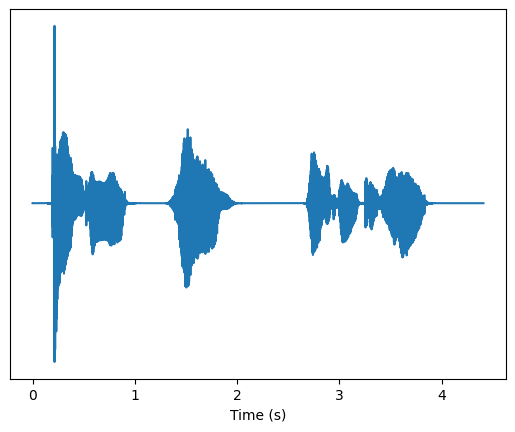

In [3]:
# Using the code from Lab 1 load one audio file and plot a waveform
audio_path = "../../asr-dataset/speech/121-121726-0002.wav"

# Load audio file
waveform, sr = torchaudio.load(audio_path)

# Plot waveform
plt.figure()
xt = torch.arange(waveform.size(1)) / sr
plt.plot(xt, waveform.T)
plt.yticks([])
plt.xlabel("Time (s)")
plt.show()

## The Discrete Fourier Transform (DFT) 

DFT is a method used by computers to analyze the frequency content of a digital audio signal. A speech recording is stored as a sequence of sampled values, and the DFT processes a finite segment of these values to determine which frequencies are present and how strong they are. The result of the DFT is a frequency-domain representation, where each frequency component corresponds to a specific frequency and an associated magnitude. In speech processing, the DFT provides a fundamental way to describe the spectral content of a signal, allowing systems to move from a time-based representation of audio to a frequency-based one, which is essential for understanding and modeling speech sounds.

## Question:

Read the documentation here and perform DFT on one audio: https://speechbrain.readthedocs.io/en/stable/tutorials/preprocessing/fourier-transform-and-spectrograms.html#short-term-fourier-transform-stft

In [4]:
# Your code here 
# DFT on the audio waveform
signal = read_audio(audio_path)
print(signal.shape)

# fft computation
fft = torch.fft.fft(signal.squeeze(), dim=0)
print(fft)
print(fft.shape)

torch.Size([70560])
tensor([1.5298+0.0000j, 1.9757-0.6308j, 1.7497-1.0954j,  ...,
        1.2369+1.6938j, 1.7497+1.0954j, 1.9757+0.6308j])
torch.Size([70560])


Compute the magnitude and phase of the DFT and plot them

Text(0.5, 0, 'Freq [Hz]')

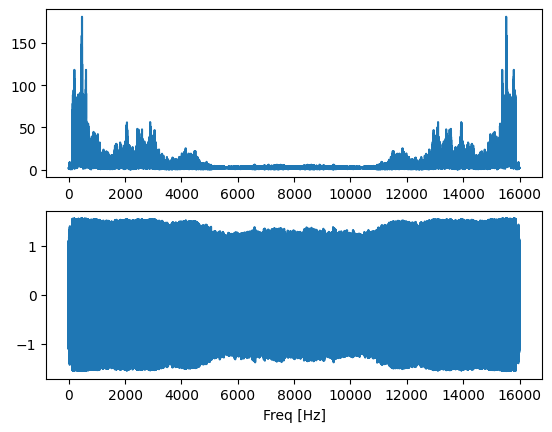

In [5]:
## Your code here

# Real and imaginary parts
real_part = fft.real
img_part = fft.imag

# Magnitude and phase
magnitude = torch.sqrt(torch.pow(real_part, 2) + torch.pow(img_part, 2))
phase = torch.arctan(img_part)

plt.subplot(211)
x_axis = torch.linspace(0, 16000, magnitude.shape[0])
plt.plot(x_axis, magnitude)

plt.subplot(212)
plt.plot(x_axis, phase)
plt.xlabel('Freq [Hz]')


## Short-Time Fourier Transform (STFT) Spectrogram — Linear Frequency Representation

Speech changes very quickly over time, so instead of analyzing the whole sound at once, we analyze it little by little. The audio signal is first cut into short pieces called frames, each lasting only a few milliseconds (typically about 25 ms), which is short enough that speech is almost stable inside each frame. These frames overlap slightly so that no information is lost at the borders and transitions remain smooth. Before analyzing each frame, we apply a window function, most commonly the Hann window, which gently fades the signal at the beginning and end of the frame to avoid artificial frequencies caused by sharp cuts. Once a frame is short, overlapping, and smoothly windowed, the computer analyzes which frequencies are present and how strong they are. By stacking the frequency information from all frames over time, we obtain a spectrogram, where:
* the horizontal axis represents time,
* the vertical axis represents frequency (evenly spaced in Hz, called linear frequency),
* and the color represents energy.

This process is called the Short-Time Fourier Transform (STFT) because we transform short pieces of sound into frequencies, revealing how speech frequencies evolve over time.

In summary, the STFT works by:
* splitting speech into short frames (e.g. 25 ms),
* applying a window (Hann),
* applying a Fourier Transform to each frame.

## Question: 

Read the documentation here and perform STFT on one audio: https://speechbrain.readthedocs.io/en/stable/tutorials/preprocessing/fourier-transform-and-spectrograms.html#short-term-fourier-transform-stft

In [6]:
#Your code here
from speechbrain.processing.features import STFT

signal = read_audio(audio_path).unsqueeze(0) # [batch, time]

compute_STFT = STFT(
    sample_rate=16000, win_length=25, hop_length=10, n_fft=400
) 

signal_STFT = compute_STFT(signal)

print(signal.shape)
print(signal_STFT.shape)

torch.Size([1, 70560])
torch.Size([1, 442, 201, 2])


Plot the spectogram reading the documentation

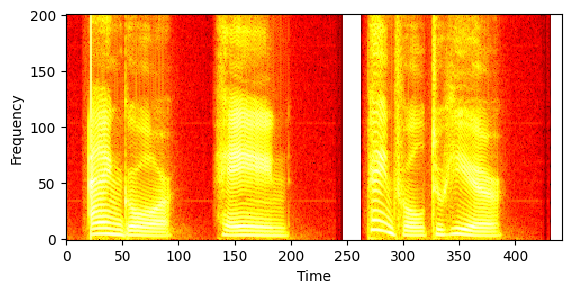

In [7]:
# Your code here
spectrogram = signal_STFT.pow(2).sum(-1) # power spectrogram
spectrogram = spectrogram.squeeze(0).transpose(0,1)

spectrogram_log = torch.log(spectrogram) # for graphical convenience

plt.imshow(spectrogram_log.squeeze(0), cmap='hot', interpolation='nearest', origin='lower')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()

## Question:

As you can see, STFT has parameters, what are they and what do they represent? Feel free to google. Explain them below in your own EASY words.

In [8]:
# Your Answer
# sample_rate – Number of audio samples per second (e.g., 16,000 Hz).

# win_length – Length of each window in ms (how much audio you analyze at once).

# hop_length – Step size to move the window forward (controls overlap between frames).

# n_fft – Number of points in the FFT (determines frequency resolution).

## Question:

Experiment by changing the parameters and producing spectograms, tell me your observations, how do the spectpgrams change as you increase/decrease each parameter? I want to see the produced spectograms.

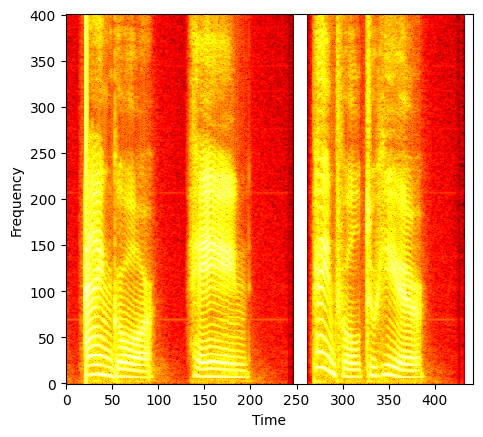

In [9]:
# Your code and your answers here

# Increase the length of the window, we can have a higher resolution in frequency
compute_STFT = STFT(sample_rate=16000, win_length=50, hop_length=10, n_fft=800)
signal_STFT = compute_STFT(signal)

spectrogram = signal_STFT.pow(2).sum(-1)
spectrogram = spectrogram.squeeze(0).transpose(0,1)
spectrogram = torch.log(spectrogram)

plt.imshow(spectrogram.squeeze(0), cmap='hot', interpolation='nearest', origin='lower')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()

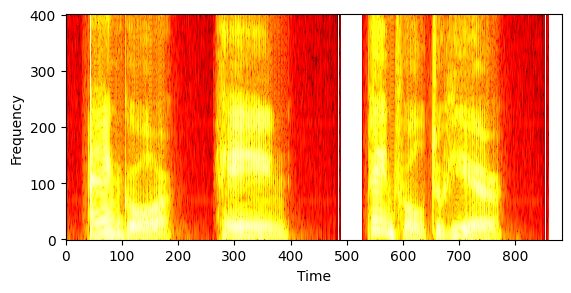

In [10]:
# Larger time resolution at the price of a reduced frequency resolution
compute_STFT = STFT(sample_rate=16000, win_length=5, hop_length=5, n_fft=800)
signal_STFT = compute_STFT(signal)

spectrogram = signal_STFT.pow(2).sum(-1)
spectrogram = spectrogram.squeeze(0).transpose(0,1)
spectrogram = torch.log(spectrogram)

plt.imshow(spectrogram.squeeze(0), cmap='hot', interpolation='nearest', origin='lower')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()

## Log-Mel Spectrogram (typical neural ASR feature)

The Mel scale is a perceptual frequency scale designed to reflect how humans hear sound rather than how frequencies are spaced mathematically. In human hearing, we are much more sensitive to small changes at low frequencies than at high frequencies, whereas the standard frequency scale (in Hertz) treats all frequency intervals equally. The Mel scale compresses high frequencies and provides finer resolution at low frequencies, making it especially suitable for speech analysis, where important information such as pitch and formants lies mostly in the lower frequency range. In ASR feature extraction, applying the Mel scale means grouping and weighting frequencies in a way that better matches human perception, which leads to features that are more robust and informative for modeling speech sounds.

## MFCC

MFCCs (Mel-Frequency Cepstral Coefficients) are a compact representation of speech that describe the overall shape of the speech spectrum in a way that is well suited for modeling and recognition. They are computed by first converting the speech signal into a Mel-scaled, log-energy spectrum, and then applying a mathematical transform that summarizes this spectrum into a small number of coefficients. This final step reduces redundancy and emphasizes the most important spectral patterns while discarding fine details that are less relevant for recognition. As a result, MFCCs provide a low-dimensional, stable description of speech and have been widely used as features in traditional ASR systems and early neural models.

## Question:

Read the documentation and produce MFCC plot: https://speechbrain.readthedocs.io/en/stable/tutorials/preprocessing/speech-features.html#mel-frequency-cepstral-coefficients-mfccs

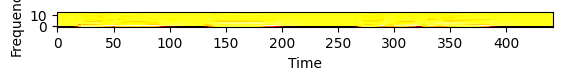

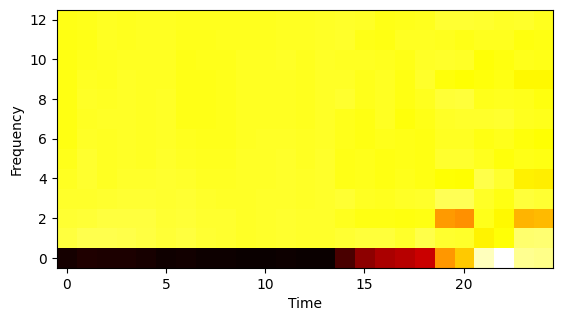

In [11]:
# Your code here 
from speechbrain.lobes.features import MFCC
mfcc_maker = MFCC(n_mfcc=13, deltas=False, context=False)
mfccs = mfcc_maker(signal)

plt.imshow(mfccs.squeeze(0).t(), cmap='hot', interpolation='nearest', origin='lower')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()

#Zoom of the first 25 steps
plt.imshow(mfccs.squeeze(0).t()[:,0:25], cmap='hot', interpolation='nearest', origin='lower')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()

# Automatic Speech Recognition: Decoders

**Name**:

The first lab introduced the building blocks of an ASR system, including feature extraction and classification with an acoustic model (wav2vec2), which produced an *emission* matrix (probability for each character at each time step). From this emission matrix, we could compute the most likely character at each time step using a naïve *greedy* decoder. The drawback of such an approach is the lack of context, which can produce sequences of characters that do not correspond to actual words, and/or sequences of words that are incorrect / do not correspond to any language rules.

In this lab, we introduce and compare multiple decoding techniques. One of the more advanced techniques is based on [connectionist temporal classification](https://towardsdatascience.com/intuitively-understanding-connectionist-temporal-classification-3797e43a86c) (CTC). The general idea of such a decoder is to consider some context (sequences of characters, possible words, and possible sequences of words), in oder to yield more likely / realistic outputs than those given by the greedy decoder.

<center><a href="https://gab41.lab41.org/speech-recognition-you-down-with-ctc-8d3b558943f0">
    <img src="https://miro.medium.com/v2/resize:fit:640/format:webp/1*XbIp4pn38rxL_DwzSeYVxQ.png" width="400"></a></center>

To do so, the CTC decoder relies on three main components:
    
- A **beam search**, which is an algorithm to efficently find the *best path* from the emission matrix, that is, the sequence of characters with highest probability (rather than the sequence of individually most likely characters).
- A **lexicon**, which is a mapping between token sequences (list of characters) and words. It is used to restrict the search space of the decoder to words that only belong to this dictionary (e.g., the word "azfpojazflj" does not exist in the English vocabulary).
- A **language model**, which specifies sequences of words that are more likely to occur than others. A common choice of language model is an $n$-gram, which is a statistical model for the probability of occurrence of a given word based on the previous $n$ ones (for instance, the sequence "the sky is" is more likely to be followed with "blue" rather than "trumpet").

The CTC decoder combines these ingredients to compute the score of several word sequences (or *hypothesis*), in order to find the best possible transcript. In this lab, we study the influence of the lexicon, language model, and the beam search size onto ASR performance from a practical perspective, without going into the technical details of the [beam search algorithm](https://www.width.ai/post/what-is-beam-search) or the [CTC loss](https://distill.pub/2017/ctc/), which can also be used for training the network (as we will see in lab 3).

**Note**: This lab is based on this [tutorial](https://pytorch.org/audio/main/tutorials/asr_inference_with_ctc_decoder_tutorial.html), which you can check for more details on CTC decoder parameters in torchaudio.

In [12]:
import torch
import torchaudio
from torchaudio.models.decoder import ctc_decoder, download_pretrained_files
import IPython
import os
import fnmatch
import matplotlib.pyplot as plt
import time
torch.random.manual_seed(0)
MAX_FILES = 2 # lower this number for processing a subset of the dataset

In [13]:
# Main dataset path - If needed, you can change it HERE but NOWHERE ELSE in the notebook!
data_dir = "../../asr-dataset"

In [14]:
# Speech and transcripts sub-directories paths
data_speech_dir = os.path.join(data_dir, 'speech')
data_transc_dir = os.path.join(data_dir, 'transcription')

## Preparation

As in the previous lab, we first load an example speech signal, and we display it. We also provide the function to get the true transcript and compute the WER. Finally, we load the wav2vec2 acoustic model.

Here we prepare our data

In [15]:
# Example file
audio_file = '61-70968-0001.wav'
audio_file_path = os.path.join(data_speech_dir, audio_file)
print(f"Audio file path: {audio_file_path}")

waveform, sr = torchaudio.load(audio_file_path, channels_first=True)
IPython.display.Audio(data=waveform, rate=sr)

Audio file path: ../../asr-dataset/speech/61-70968-0001.wav


In [16]:
# We provide the function for loading the true transcript and computing the WER
def get_true_transcript(transc_file_path):
    with open(transc_file_path, "r") as f:
        true_transcript = f.read()
    true_transcript = true_transcript.lower().split()
    return true_transcript

def get_wer(true_transcript, est_transcript):
    wer = torchaudio.functional.edit_distance(true_transcript, est_transcript) / len(true_transcript)
    return wer
    

In [17]:
# Load and display the true transcription
transc_file_path = os.path.join(data_transc_dir, audio_file.replace('wav', 'txt'))
true_transcript = get_true_transcript(transc_file_path)
print(true_transcript)

['give', 'not', 'so', 'earnest', 'a', 'mind', 'to', 'these', 'mummeries', 'child']


Here we load an accoustic model for our ASR

## Question:

Remember and explain again what does an accoustic model do?

In [18]:
# Your answer
# The features are transformed into high-diemnsional embeddings via a deep neural network, and then a classifier is applied to
# predict the class of each token at each time step.

In [19]:
# Load the acoustic model
model_name = 'WAV2VEC2_ASR_BASE_100H'
bundle = getattr(torchaudio.pipelines, model_name)
acoustic_model = bundle.get_model()
labels = bundle.get_labels()

# Apply the model to the waveform to get the emission tensor
with torch.inference_mode():
    emission, _ = acoustic_model(waveform)
    num_time_steps = emission.shape[1]


## Question:

We are trying to run an ASR now, however, we are yet to see any steps for feature extraction. Where does feature extraction happen and why can't you see it? https://docs.pytorch.org/audio/main/tutorials/speech_recognition_pipeline_tutorial.html

### Answer: 
Inside the Wav2Vec2 model, Because the model learns feature extraction, so you don’t call extractors manually.



## Question:

What is the purpose of a decoder in your own words:

In [20]:
# Your answer
# The decoder in ASR converts the extracted features into words or text, usually by finding the most likely sequence of words given the audio.

## CTC Decoder

The CTC decoder can be constructed directly by using the `ctc_decoder` function in torchaudio. In addition to the parameters related to the beam search (we will study them later on), it takes as inputs:
- the list of tokens, in order to map emissions to characters in the classifier.
- the path to the lexicon, expected as a .txt file containing, on each line, a word followed by its space-split tokens (and special end-of-sequence token `|`):

```
# lexicon.txt
a     a |
able  a b l e |
about a b o u t |
...
```
- the path to the language model, expected as a .bin file.

All these are assembled in pretrained files that can be downloaded using the `download_pretrained_files` function (this might take some time as the language model can be large), and then used to contruct the decoder.

In [21]:
# Download the files corresponding to (pretrained) language model, which comes with lexicon and tokens
files = download_pretrained_files("librispeech")
path_lm_tokens = files.tokens
path_lm_lexicon = files.lexicon
path_lm = files.lm

print(path_lm_tokens)
print(path_lm_lexicon)
print(path_lm)

/home/mirzadeh/.cache/torch/hub/torchaudio/decoder-assets/librispeech/tokens.txt
/home/mirzadeh/.cache/torch/hub/torchaudio/decoder-assets/librispeech/lexicon.txt
None


In [22]:
# Vizualize the first 10 tokens (includes the blank and end-of-word token)
with open(path_lm_tokens, 'r') as f:
    tok = f.read().splitlines()
print("\n".join(tok[:10]))

-
|
e
t
a
o
n
i
h
s


## Question:

What is the purpose of the lexicon here?

In [ ]:
# Your answer here
# In ASR, the lexicon is a file that maps words to their pronunciations.

In [24]:
# Vizualize the lexicon content (first 10 entries)
with open(path_lm_lexicon, 'r') as f:
    lex = f.read().splitlines()
print("\n".join(lex[:10]))

a	a |
a''s	a ' ' s |
a'body	a ' b o d y |
a'court	a ' c o u r t |
a'd	a ' d |
a'gha	a ' g h a |
a'goin	a ' g o i n |
a'll	a ' l l |
a'm	a ' m |
a'mighty	a ' m i g h t y |


In [25]:
# To obtain the line(s) corresponding to a word in the lexicon, you can use the following:
w = 'hello'
lex_w = [line for line in open(path_lm_lexicon) if line.startswith(w + '\t')] # it's a list since there could be different pronunciation for the same word
print(lex_w)

['hello\th e l l o |\n']


In [26]:
# Instanciate the CTC decoder
decoder = ctc_decoder(
    lexicon=path_lm_lexicon,
    tokens=path_lm_tokens,
    lm=path_lm,
)

# Apply the decoder to the `emission` tensor, and get the first element (batch_size=1) and best hypothesis
ctc_decoder_result = decoder(emission)[0][0]

The decoder output `ctc_decoder_result` contains many fields, including the predicted token IDs, and a `.words` field that contains the transcript as a list of strings.

In [27]:
# Get the token IDs using the .tokens field
ctc_decoder_indices = ctc_decoder_result.tokens
print(f"Token indices: {ctc_decoder_indices}")

# Display the transript using the .words field
print(f"Words: {ctc_decoder_result.words}")

Token indices: tensor([ 1, 18,  7, 22,  2,  1,  6,  5,  3,  1,  9,  5,  1,  2,  4, 10,  6,  2,
         9,  3,  1,  4,  1, 14,  7,  6, 11,  1,  3,  5,  1,  3,  8,  2,  9,  2,
         1, 14,  2, 14,  5, 10,  7,  2,  9,  1, 16,  8,  7, 12, 11,  1,  1])
Words: ['give', 'not', 'so', 'earnest', 'a', 'mind', 'to', 'these', 'memories', 'child']


### Greedy decoder

The greedy decoder we have seen in the first lab is a particular case of the CTC decoder when no langage model / lexicon is provided. It can be constructed by simply passing `None` as corresponding input arguments in the `ctc_decoder` function.

In [28]:
# TO DO: Construct a greedy decoder (no LM / lexicon), and apply it to the emission matrix
decoder_nolm = ctc_decoder(
    lexicon=None,
    tokens=path_lm_tokens,
    lm=None
)

ctc_nolm_result = decoder_nolm(emission)[0][0]

In [29]:
# Since no language model is provided, the .words field returns an empty list
print(ctc_nolm_result.words)

# Then we have to manually convert token IDs to tokens using the decoder.idxs_to_tokens method
# (+ a bit of postprocessing)
ctc_nolm_tokens = decoder.idxs_to_tokens(ctc_nolm_result.tokens)
ctc_nolm_transcript = "".join(ctc_nolm_tokens).replace("|", " ").strip().split() 
ctc_nolm_transcript = [w.lower() for w in ctc_nolm_transcript]

print(f"No LM Transcript: {ctc_nolm_transcript}")

[]
No LM Transcript: ['give', 'not', 'so', 'earnest', 'a', 'mind', 'to', 'these', 'mumories', 'child']


## Beam Search vs Greedy decoder

## Question:

Explain how the Greedy and Beam decoders work: https://medium.com/nlplanet/two-minutes-nlp-most-used-decoding-methods-for-language-models-9d44b2375612

In [30]:
# Your Answer
# Greedy decoder: Always picks the most likely next token at each step. Fast but can miss the best overall sentence because
# it ignores lower-probability options that could lead to better sequences.

# Beam decoder: Keeps track of the top N most likely sequences (beams) at each step and chooses
# the overall most probable sequence at the end. Slower but usually produces more accurate and fluent outputs than greedy decoding.

## Question:

Time to try coding it yourself. Refering to the codes in lab 1 and this lab, run an asr using your chosen wav2vec accoustic model with both of these decoders on 10 audio files and compare the average WERs. Comment on the difference.

In [31]:
def find_files(directory, pattern='*.wav'):
    """Recursively finds all files matching the pattern."""
    files = []
    for root, _, filenames in os.walk(directory):
        for filename in fnmatch.filter(filenames, pattern):
            files.append(filename)
    files = sorted(files)
    return files


def process_folder(data_speech_dir, data_transc_dir, acoustic_model, decoder, verbose=True, max_files=None):

    # Get the list of files in the dataset folder
    audio_files = find_files(data_speech_dir)

    # Take a subset of files
    nfiles = len(audio_files)
    if max_files:
        nfiles = min(nfiles, max_files)
    audio_files = audio_files[:nfiles]

    # Initialize lists containing true and estimated transcripts, as well as WER
    true_transcript_all = []
    est_transcript_all = []
    wer_all = []

    for iaf, audio_file in enumerate(audio_files):
        
        # Get files path
        audio_file_path = os.path.join(data_speech_dir, audio_file)
        transc_file_path = os.path.join(data_transc_dir, audio_file.replace('wav', 'txt'))

        # Load an audio signal
        waveform, sr = torchaudio.load(audio_file_path, channels_first=True)

        # Apply acoustic model and decoder
        with torch.inference_mode():
            emission, _ = acoustic_model(waveform)
            ctc_decoder_results = decoder(emission)[0][0]

        ctc_tokens = decoder.idxs_to_tokens(ctc_decoder_results.tokens)
        est_transcript = "".join(ctc_tokens).replace("|", " ").strip().split()
        est_transcript = [w.lower() for w in est_transcript]

        # Load the true transcription
        true_transcript = get_true_transcript(transc_file_path)
        
        # Compute WER
        wer = get_wer(true_transcript, est_transcript)
        wer_all.append(wer)

        est_transcript_all.append(est_transcript)
        true_transcript_all.append(true_transcript)
        
        # Display results
        if verbose:
            print(f"File {iaf+1} / {nfiles}")
            print('Estimated transcript: ', est_transcript)
            print('True transcript: ', true_transcript)
            print(f"WER: {wer*100:.1f} %")

    wer_mean = torch.FloatTensor(wer_all).mean()

    return wer_mean, est_transcript_all, true_transcript_all

In [32]:
# Beam search decoder
wer_beam, est_beam, true_beam = process_folder(
    data_speech_dir, data_transc_dir, acoustic_model, decoder, max_files=10, verbose=True
)

# Greedy decoder
wer_greedy, est_greedy, true_greedy = process_folder(
    data_speech_dir, data_transc_dir, acoustic_model, decoder_nolm, max_files=10, verbose=True
)

print(f"Average WER with Beam decoder: {wer_beam*100:.2f} %")
print(f"Average WER with Greedy decoder: {wer_greedy*100:.2f} %")

File 1 / 10
Estimated transcript:  ['ango', 'hane', 'painful', 'to', 'hear']
True transcript:  ['angor', 'pain', 'painful', 'to', 'hear']
WER: 40.0 %
File 2 / 10
Estimated transcript:  ['heaven', 'a', 'good', 'place', 'to', 'be', 'raised', 'to']
True transcript:  ['heaven', 'a', 'good', 'place', 'to', 'be', 'raised', 'to']
WER: 0.0 %
File 3 / 10
Estimated transcript:  ['hedge', 'offence']
True transcript:  ['hedge', 'a', 'fence']
WER: 66.7 %
File 4 / 10
Estimated transcript:  ['heredity', 'the', 'cause', 'of', 'all', 'our', 'faults']
True transcript:  ['heredity', 'the', 'cause', 'of', 'all', 'our', 'faults']
WER: 0.0 %
File 5 / 10
Estimated transcript:  ['hos', "man's", 'excuse', 'for', 'wetting', 'the', 'walk']
True transcript:  ['hose', "man's", 'excuse', 'for', 'wetting', 'the', 'walk']
WER: 14.3 %
File 6 / 10
Estimated transcript:  ['husband', 'the', 'next', 'thing', 'to', 'a', 'wife']
True transcript:  ['husband', 'the', 'next', 'thing', 'to', 'a', 'wife']
WER: 0.0 %
File 7 / 10


## Influence of the language model

The language model is also expected to have a strong impact onto performance, since it guides the decoder towards more likely word sequences.

<span style="color:red"> **Exercise 1**</span>. Compare the CTC decoder using `librispeech-4-gram` files (lexicon, token, and language model downloaded above in this script) and the greedy decoder. To that end, for each decoder, perform ASR on the whole dataset (feel free to reuse/adapt code from the previous lab) and compute the mean WER. Can you interprete the results?

In [33]:
def find_files(directory, pattern='*.wav'):
    """Recursively finds all files matching the pattern."""
    files = []
    for root, _, filenames in os.walk(directory):
        for filename in fnmatch.filter(filenames, pattern):
            files.append(filename)
    files = sorted(files)
    return files


def process_folder(data_speech_dir, data_transc_dir, acoustic_model, decoder, verbose=True, max_files=None):

    # Get the list of files in the dataset folder
    audio_files = find_files(data_speech_dir)

    # Take a subset of files
    nfiles = len(audio_files)
    if max_files:
        nfiles = min(nfiles, max_files)
    audio_files = audio_files[:nfiles]

    # Initialize lists containing true and estimated transcripts, as well as WER
    true_transcript_all = []
    est_transcript_all = []
    wer_all = []

    for iaf, audio_file in enumerate(audio_files):
        
        # Get files path
        audio_file_path = os.path.join(data_speech_dir, audio_file)
        transc_file_path = os.path.join(data_transc_dir, audio_file.replace('wav', 'txt'))

        # Load an audio signal
        waveform, sr = torchaudio.load(audio_file_path, channels_first=True)

        # Apply acoustic model and decoder
        with torch.inference_mode():
            emission, _ = acoustic_model(waveform)
            ctc_decoder_results = decoder(emission)[0][0]

        ctc_tokens = decoder.idxs_to_tokens(ctc_decoder_results.tokens)
        est_transcript = "".join(ctc_tokens).replace("|", " ").strip().split()
        est_transcript = [w.lower() for w in est_transcript]

        # Load the true transcription
        true_transcript = get_true_transcript(transc_file_path)
        
        # Compute WER
        wer = get_wer(true_transcript, est_transcript)
        wer_all.append(wer)

        est_transcript_all.append(est_transcript)
        true_transcript_all.append(true_transcript)
        
        # Display results
        if verbose:
            print(f"File {iaf+1} / {nfiles}")
            print('Estimated transcript: ', est_transcript)
            print('True transcript: ', true_transcript)
            print(f"WER: {wer*100:.1f} %")

    wer_mean = torch.FloatTensor(wer_all).mean()

    return wer_mean, est_transcript_all, true_transcript_all

In [34]:
# CTC decoder with the 4-gram language model
decoder = ctc_decoder(
    lexicon=path_lm_lexicon,
    tokens=path_lm_tokens,
    lm=path_lm,
)
wer_mean = process_folder(data_speech_dir, data_transc_dir, acoustic_model, decoder, verbose=False, max_files=MAX_FILES)[0]
print(f"LM: --- WER: {wer_mean*100:.1f} %")

# Greedy decoder
decoder = ctc_decoder(
    lexicon=None,
    tokens=labels,
    lm=None,
)
wer_mean = process_folder(data_speech_dir, data_transc_dir, acoustic_model, decoder, verbose=False, max_files=MAX_FILES)[0]
print(f"Greedy Decoder --- WER: {wer_mean*100:.1f} %")

LM: --- WER: 20.0 %
Greedy Decoder --- WER: 10.0 %


### Answer:
The greedy decoder gives lower WER (10% vs 20%), showing the LM can hurt performance if it mismatches the dataset.

## Influence of the lexicon

The lexicon is expected to have a strong influence on ASR performance, since it constrains the decoder to produce only words that belong to this lexicon, therefore avoiding to procude words that potentially do not exist in a language or given corpus. Here, we propose to use a custom lexicon that only contains words that are in the dataset.

<span style="color:red"> **Exercise 2**</span>. Perform ASR using such a custom lexicon. To that end:
- Build a vocabulary (list of words) from the transcript files in the dataset (load the transcripts and remove duplicates).
- Filter the downloaded lexicon by only keeping words from the vocabulary. Write this custom lexicon as a `.txt` file.
- Create a dedocer that uses the 4-gram language model and this custom lexicon. Perform ASR on the dataset / compute the WER. What do you observe?

In [35]:
# Fonction to get a flat list from a list of list
def flatten_list(list_of_lists):
    return [x for L in list_of_lists for x in L]

# Read all the transcripts in the dataset
transcr_files = find_files(data_transc_dir, pattern='*.txt')
true_transcript = []
for f in transcr_files:
    transc_file_path = os.path.join(data_transc_dir, f)
    true_transcript.append(get_true_transcript(transc_file_path))

# Flatten the list and remove duplicates
vocab_dataset = list(set(flatten_list(true_transcript)))
print('Words in the dataset:', len(vocab_dataset))

# Filter the provided lexicon by keeping only words in our dataset
custom_lexicon = []
for w in vocab_dataset:
    wl = [line for line in open(files.lexicon) if line.startswith(w + '\t')]
    custom_lexicon.append(wl)

# again, flatten it
custom_lexicon = flatten_list(custom_lexicon)

# There are less entries in the lexicon than in our list of words from the dataset: several words are indeed not registered in the lexicon (we could add them manually)
print('Entries in the custom lexicon: ', len(custom_lexicon))

# Record this lexicon
with open("mylexicon.txt", "w") as f:
    f.writelines(custom_lexicon)

Words in the dataset: 448
Entries in the custom lexicon:  440


In [36]:
# CTC decoder with the language model + a custom lexicon
decoder = ctc_decoder(
    lexicon="mylexicon.txt",
    tokens=path_lm_tokens,
    lm=path_lm,
)
wer_mean = process_folder(data_speech_dir, data_transc_dir, acoustic_model, decoder, verbose=False, max_files=MAX_FILES)[0]
print(f"Custom lexicon --- WER: {wer_mean*100:.1f} %")

Custom lexicon --- WER: 20.0 %


## Question:

How does this custom lexicon compare to the one we used before? How does it affect WER and why?

### Answer:
The custom lexicon performs the same as the original lexicon, giving a WER of 20%, which means it does not add useful constraints for this dataset. In contrast, the greedy decoder achieves a lower WER (10%) because it is not restricted by a mismatched language model or lexicon. This shows that an unsuitable lexicon or LM can degrade ASR performance instead of improving it.

## Beam search parameters

The beam search algorithm used in the CTC decoder depends on other parameters, such as `nbest` which determines the number of hypotheses to return, or `lm_weight` which adjust the relative importance of the language model vs. the acoustic model predictions. Here we only focus on `beam_size`, which determines the maximum number of best hypotheses to hold after each decoding step. Using larger beam sizes allows for exploring a larger range of possible hypotheses which can produce hypotheses with higher scores, which really is [the core](https://distill.pub/2017/ctc/) of the beam search algorithm.

<span style="color:red"> **Exercise 3**</span>. Perform ASR on the whole dataset folder for several values of the beam search size parameter: `beam_size` $\in [1, 10, 100]$ (use the original downloaded lexicon, not the custom one). Compute the WER and the computation time (e.g., via the [time](https://docs.python.org/3/library/time.html#time.time) package). What do you observe?

In [37]:
beam_sizes = [1, 10, 100]

for beam_size in beam_sizes:
    decoder = ctc_decoder(
        lexicon=path_lm_lexicon,
        tokens=path_lm_tokens,
        lm=path_lm,
        beam_size=beam_size,
    )

    time_start = time.time()
    wer_mean = process_folder(data_speech_dir, data_transc_dir, acoustic_model, decoder, verbose=False, max_files=MAX_FILES)[0]
    time_ellapsed = time.time() - time_start

    print(f"Beam search size: {beam_size} --- WER: {wer_mean*100:.1f} % --- Time: {time_ellapsed:.1f}")

Beam search size: 1 --- WER: 20.0 % --- Time: 1.0
Beam search size: 10 --- WER: 20.0 % --- Time: 1.3
Beam search size: 100 --- WER: 20.0 % --- Time: 1.1


## Question:

Compare the performance using different beam sizes

In [38]:
# Your answer
# Increasing the beam size increases decoding time but does not improve WER in this experiment.
# This suggests that the correct hypotheses were already found with a small beam, and larger beams
# only add computational cost without accuracy benefits.

## Question:

What other parameters could we tweak and what are they responsible for? Try tweaking them, how does it affect WER? 
https://docs.pytorch.org/audio/2.8/tutorials/asr_inference_with_ctc_decoder_tutorial.html#beam-search-decoder

In [39]:
lm_weights = [0.5, 1.0, 2.0]

for lm_weight in lm_weights:
    decoder = ctc_decoder(
        lexicon=path_lm_lexicon,
        tokens=path_lm_tokens,
        lm=path_lm,
        beam_size=10,
        lm_weight=lm_weight
    )

    time_start = time.time()
    wer_mean = process_folder(data_speech_dir, data_transc_dir, acoustic_model, decoder, verbose=False, max_files=MAX_FILES)[0]
    time_ellapsed = time.time() - time_start

    print(f"LM weight: {lm_weight} --- WER: {wer_mean*100:.1f} % --- Time: {time_ellapsed:.1f}")
    
word_scores = [-2.0, -1.0, 0.0]

for word_score in word_scores:
    decoder = ctc_decoder(
        lexicon=path_lm_lexicon,
        tokens=path_lm_tokens,
        lm=path_lm,
        beam_size=10,
        word_score=word_score
    )

    time_start = time.time()
    wer_mean = process_folder(data_speech_dir, data_transc_dir, acoustic_model, decoder, verbose=False, max_files=MAX_FILES)[0]
    time_ellapsed = time.time() - time_start

    print(f"Word score: {word_score} --- WER: {wer_mean*100:.1f} % --- Time: {time_ellapsed:.1f}")
        
    


LM weight: 0.5 --- WER: 20.0 % --- Time: 1.0
LM weight: 1.0 --- WER: 20.0 % --- Time: 1.0
LM weight: 2.0 --- WER: 20.0 % --- Time: 1.2
Word score: -2.0 --- WER: 20.0 % --- Time: 1.1
Word score: -1.0 --- WER: 20.0 % --- Time: 1.5
Word score: 0.0 --- WER: 20.0 % --- Time: 1.4


## Coding blocks and questions that will be tested next class:

In [ ]:
from speechbrain.processing.features import STFT

signal = read_audio('').unsqueeze(0) 
# Why do we need to unsqueeze it???

compute_STFT = STFT(sample_rate=16000, win_length=25, hop_length=10, n_fft=400) # 25 ms, 10 ms
signal_STFT = compute_STFT(signal)

In [ ]:
spectrogram = signal_STFT.pow(2).sum(-1) # power spectrogram
spectrogram = spectrogram.squeeze(0).transpose(0,1)

spectrogram_log = torch.log(spectrogram) # for graphical convenience

plt.imshow(spectrogram_log.squeeze(0), cmap='hot', interpolation='nearest', origin='lower')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()

* What is the difference between waveform and spectrogram?
* what is pseudo-likelihood and how is it obtained? (Google or refer to your lecture slides)
* What is the STFT and why is it used for speech?
* What do n_fft, window length, and hop length control?
* What is the difference between log-Mel features and MFCCs?
* Is pitch a relevant acoustic feature for voice command task in Chinese language? Why? What about French?
* What is the benefit of the TDNN architecture compared to a conventional CNN? Explain both architectures. (You will need to google for this one or refer to your lecture slides)



## Last Question with a bit of context:
Conceptually, a decoder objective is to search for the most likely sequence of words:

![Decoder objective](fig1.png)

https://jonathan-hui.medium.com/speech-recognition-asr-decoding-f152aebed779

The formula above means:
“among all possible sentences, choose the one that has the highest probability given the audio.”

Now look at the formula below, given that the left side represents the probability of a sentence given the audio, what does it mean? What does the sign between them mean?

![Decoder decomposition](fig2.png)
